In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from tqdm import trange
from tqdm.notebook import tnrange

from sklearn import preprocessing
import pandas as pd
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
def transform_dataset(df):
    """

    :param df:
    :return: Tuple of the transformed dataset and the labels Y and S
    """

    df_binary = df[(df["race"] == "Caucasian") | (df["race"] == "African-American")]

    del df_binary['c_jail_in']
    del df_binary['c_jail_out']

    ##separated class from the rests of the features
    # remove unnecessary dimensions from Y -> only the decile_score remains
    Y = df_binary['decile_score']    
    del df_binary['decile_score']
    Y_true = df_binary['two_year_recid']
    del df_binary['two_year_recid']
    del df_binary['score_text']

    S = df_binary['race']
    del df_binary['race']
    del df_binary['is_recid']

    # set sparse to False to return dense matrix after transformation and keep all dimensions homogeneous
    encod = preprocessing.OneHotEncoder(sparse=False)
    
    data_to_encode = df_binary.to_numpy()
    feat_to_encode = data_to_encode[:, 0]
    # print(feat_to_encode)
    # transposition
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    # print(feat_to_encode)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.DataFrame(encoded_feature)

    feat_to_encode = data_to_encode[:, 1]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_encoded_feature = pd.DataFrame(encoded_feature)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    # feature [2] [3] [4] [5] [6] [7] [8] has to be put between 0 and 1

    for i in range(2, 9):
        encoded_feature = data_to_encode[:, i]
        ma = np.amax(encoded_feature)
        mi = np.amin(encoded_feature)
        encoded_feature = (encoded_feature - mi) / (ma - mi)
        df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    feat_to_encode = data_to_encode[:, 9]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_encoded_feature = pd.DataFrame(encoded_feature)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    return df_binary_encoded, Y, S, Y_true


In [15]:
df = pd.read_csv(os.path.join("..", "data", "csv", "scikit",
                                  "compas_recidive_two_years_sanitize_age_category_jail_time_decile_score.csv"))

df_binary, Y, S, Y_true = transform_dataset(df)

#df_outcome = pd.DataFrame(np.array([S, Y]).T, columns=['race', 'true'])


In [16]:
x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
y_tensor = torch.tensor(Y.to_numpy().reshape(-1,1).astype(np.float32))
l_tensor = torch.tensor(Y_true.to_numpy().reshape(-1,1).astype(np.float32))
s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())

In [17]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor, s_tensor):
        self.x = x_tensor
        self.y = y_tensor
        self.s = s_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index], self.s[index]

    def __len__(self):
        return len(self.x)

In [18]:
dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor) # dataset = CustomDataset(x_tensor, y_tensor)

In [19]:
base_size = len(dataset)//10
split = [7*base_size,1*base_size, len(dataset)-8*base_size] # Train, validation, test

In [20]:
train_dataset, val_dataset, test_dataset = random_split(dataset, split)

In [21]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128)
test_loader = DataLoader(dataset=test_dataset, batch_size=128)

In [22]:
from torch.autograd import Function

class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None


class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [92]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.grl = GradientReversal(100)
        self.fc4 = nn.Linear(64, 2)
        
        #self.grl = GradientReversal(100)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.1)
        x = self.fc2(x)
        x = F.relu(x)
        hidden = F.dropout(x, 0.1)
        y = self.fc3(hidden)
        y = F.dropout(y, 0.1)
        s = self.grl(hidden)
        s = self.fc4(s)
        #s = F.sigmoid(s)
        s = F.dropout(s, 0.1)
        return y,s

In [93]:
def make_train_step(model: Net, loss_fn, optimizer):
    def _train_step(x, y):
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        optimizer.step()
        return loss.item()
    return _train_step

In [94]:
def weights_init_uniform_rule(m):
        classname = m.__class__.__name__
        # for every Linear layer in a model..
        if classname.find('Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)
            

In [95]:
torch.manual_seed(0)

model = Net()
criterion = nn.MSELoss()
criterion_bias = nn.CrossEntropyLoss()
optimizer =optim.Adagrad(model.parameters())

n_epochs = 3000
training_losses = []
validation_losses = []

In [96]:
t_prog = trange(n_epochs, desc='Progress', leave=True)
#t_prog = trange(50)

for epoch in range(n_epochs):
    model.train()

    batch_losses = []
    for x_batch, y_batch, _,s_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
         # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, outputs_protected = model(x_batch)
        loss = criterion(outputs, y_batch) + criterion_bias(outputs_protected, s_batch.argmax(dim=1))
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    training_loss = np.mean(batch_losses)
    training_losses.append(training_loss)

    with torch.no_grad():
        val_losses = []
        for x_val, y_val, _,s_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()
            yhat, s_hat = model(x_val)
            val_loss = (criterion(y_val, yhat) + criterion_bias(s_val, s_hat.argmax(dim=1))).item()
            val_losses.append(val_loss)
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)
    if epoch % 50 == 0:
        print({"epoch": epoch, "training_loss": training_loss, "validation_loss": validation_loss})  # print last metrics








Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

{'epoch': 0, 'training_loss': 15.887411380636282, 'validation_loss': 10.96130426462597}
{'epoch': 50, 'training_loss': 9.227819278322418, 'validation_loss': 9.414240901232821}
{'epoch': 100, 'training_loss': 9.746819315285519, 'validation_loss': 9.709880142769281}
{'epoch': 150, 'training_loss': 9.522100415723077, 'validation_loss': 10.454210262855948}
{'epoch': 200, 'training_loss': 9.832316661703176, 'validation_loss': 10.05315453267203}
{'epoch': 250, 'training_loss': 9.889917603854474, 'validation_loss': 9.633824876706862}
{'epoch': 300, 'training_loss': 9.854818344116211, 'validation_loss': 10.80963932728873}
{'epoch': 350, 'training_loss': 9.873116871406292, 'validation_loss': 9.526024774472974}
{'epoch': 400, 'training_loss': 9.472506079180487, 'validation_loss': 9.330274480741284}
{'epoch': 450, 'training_loss': 10.142514787871262, 'validation_loss': 9.766057758888664}
{'epoch': 500, 'training_loss': 9.853647511580895, 'validation_loss': 10.281211046140454}
{'epoch': 550, 'trai

KeyboardInterrupt: 

In [ ]:
criterion_bias(outputs_protected, s_batch.argmax(dim=1))

In [ ]:
s_batch

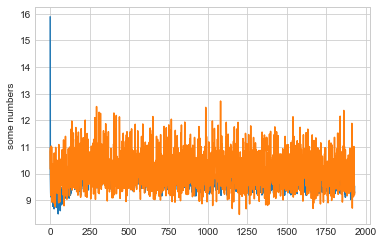

In [97]:
import matplotlib.pyplot as plt

plt.plot(range(len(training_losses)), training_losses)
plt.plot(range(len(validation_losses)), validation_losses)
#plt.scatter(x_tensor, y_out.detach().numpy())
plt.ylabel('some numbers')
plt.show()

In [98]:
with torch.no_grad():
    test_losses = []
    test_results = []
    for x_test, y_test, ytrue, s_true in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        model.eval()
        yhat, s_hat = model(x_test)
        print(yhat.shape)
        test_loss = (criterion(y_test, yhat) + criterion_bias(s_true, s_hat.argmax(dim=1))).item()
        test_losses.append(val_loss)
        test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true, "s_hat": s_hat})
    print({"Test loss": np.mean(test_losses)})
 

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([38, 1])
{'Test loss': 9.743131720782383}


In [99]:
results             = test_results[0]['y_hat']
outcome             = test_results[0]['y_true']
compas              = test_results[0]['y_compas']
protected_results   = test_results[0]['s']
protected              = test_results[0]['s_hat']
for r in test_results[1:]:
    results = torch.cat((results, r['y_hat']))
    outcome = torch.cat((outcome, r['y_true']))
    compas = torch.cat((compas, r['y_compas']))
    protected_results = torch.cat((protected_results, r['s']))
    protected = torch.cat((protected, r['s_hat']))
    print(results.shape)
   

torch.Size([256, 1])
torch.Size([384, 1])
torch.Size([512, 1])
torch.Size([640, 1])
torch.Size([768, 1])
torch.Size([896, 1])
torch.Size([1024, 1])
torch.Size([1062, 1])


In [100]:
((results[:,0] > 8) == outcome[:,0]).float().mean() 

tensor(0.5471)

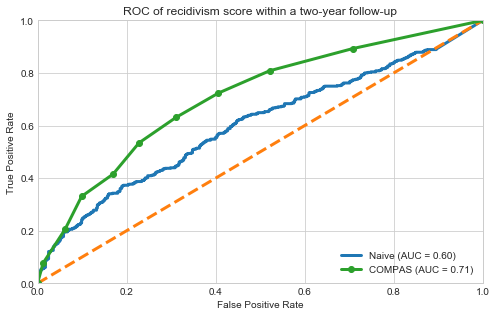

In [101]:
from sklearn.metrics import roc_curve, auc, confusion_matrix



fig = plt.figure()
fig.set_size_inches(7,4.5)
plt.style.use('seaborn-whitegrid')
plt.title('ROC of recidivism score within a two-year follow-up')

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(outcome[:,0], results[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-",
    label='Naive (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.plot([0,1],[0,1],'--', linewidth=3)

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(outcome[:,0], compas[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-o",
    label='COMPAS (AUC = %0.2f)'% roc_auc,  linewidth=3)



# COMPAS ROC
#false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction['two_year_recid'], prediction['true'])
#roc_auc = auc(false_positive_rate, true_positive_rate)
#plt.plot(false_positive_rate, true_positive_rate, "-o",
#label='COMPAS decile (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.legend(loc='lower right')


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

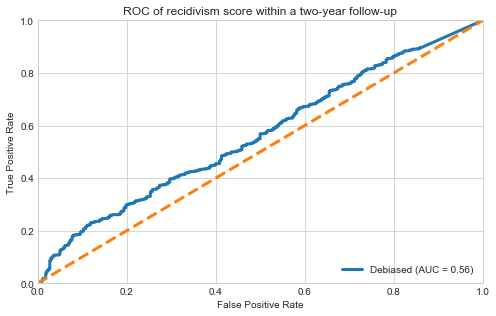

In [102]:
from sklearn.metrics import roc_curve, auc, confusion_matrix



fig = plt.figure()
fig.set_size_inches(7,4.5)
plt.style.use('seaborn-whitegrid')
plt.title('ROC of recidivism score within a two-year follow-up')

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(protected_results[:,0], protected[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-",
    label='Debiased (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.plot([0,1],[0,1],'--', linewidth=3)

# COMPAS ROC
#false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction['two_year_recid'], prediction['true'])
#roc_auc = auc(false_positive_rate, true_positive_rate)
#plt.plot(false_positive_rate, true_positive_rate, "-o",
#label='COMPAS decile (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.legend(loc='lower right')


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()
#fig.savefig("roc_curve.png", dpi=300,  transparent=True)

In [68]:
protected[:,0]

tensor([ 0.7203,  0.0000,  0.1002,  ...,  0.2929,  0.0000, -0.2357])

In [ ]:
criterion(yhat, y_val)

In [ ]:
x = np.random.rand(100, 1)
true_a, true_b = 1, 2
y = true_a + true_b*x + 0.1*np.random.randn(100, 1)

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()
y_out = model(x_tensor.to(device))

In [ ]:
x_val = x_val.to(device)
y_val = y_val.to(device)
model.eval()
yhat = model(x_val)
val_loss = loss_fn(y_val, yhat).item()



In [44]:
np.power(y_val - yhat, 2).mean()

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [144]:
for param in model.parameters():
    print(param.grad.data)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0

In [155]:
list(model.parameters())

[Parameter containing:
 tensor([[ 4.0856e-01,  5.5243e-01,  2.1139e-01,  2.6691e-01,  3.7668e-01,
           4.7115e-01,  3.0615e-01,  5.7431e-01,  6.8628e-01,  1.2031e-01,
           6.4158e-01,  4.5927e-01,  5.3671e-01,  2.6466e-01],
         [ 3.4428e-01,  3.1861e-01,  4.9203e-01,  7.5094e-02,  3.5684e-01,
           5.0246e-01,  3.3781e-01,  4.1498e-01,  3.6497e-01,  5.1734e-01,
           2.2656e-01,  3.1429e-01,  2.8738e-01,  8.8778e-02],
         [-1.2733e-01, -3.1131e-01,  1.5977e-01, -2.3552e-01,  1.0989e-01,
          -1.0126e-02, -1.5756e-01,  7.8926e-02, -6.4677e-02,  1.2641e-01,
          -5.6828e-02, -1.7025e-01, -1.7776e-02, -1.4091e-01],
         [ 5.6479e-02,  1.4419e-01,  9.9368e-02, -1.5950e-01, -2.0727e-03,
          -5.8372e-02,  2.1892e-02, -2.5891e-01, -3.7247e-01, -1.8967e-01,
          -3.0807e-01,  1.1621e-01, -8.6486e-03,  1.6472e-02],
         [ 8.4524e-02, -4.6493e-03,  2.0916e-01, -1.8989e-01,  1.6828e-02,
          -1.8242e-01,  8.2411e-02, -9.2040e-02,  

In [21]:


model.parameters()

TypeError: object of type 'generator' has no len()

In [226]:
next(model.parameters())

Parameter containing:
tensor([[-0.4596, -0.4801, -0.1890, -0.2595, -0.1941, -0.3064, -0.3068, -0.3105,
         -0.1559, -0.4852, -0.2427, -0.1537, -0.1453, -0.1283],
        [ 0.0691, -0.4681, -0.1008,  0.1321, -0.3256, -0.0397, -0.7015, -0.4624,
         -0.4131, -0.5376, -0.3318, -0.0903, -0.1572,  0.0254],
        [ 0.0171,  0.2248,  0.3542,  0.4232,  0.0694, -0.1471, -0.1106,  0.1885,
          0.0746,  0.2128, -0.1539, -0.1257,  0.2850,  0.2253],
        [-0.0057,  0.3682,  0.0051, -0.0668,  0.2217, -0.0569, -0.1469, -0.1675,
          0.1199,  0.0864,  0.2091, -0.1216,  0.0618,  0.3818],
        [ 0.0100, -0.1024, -0.0256, -0.2190, -0.1881,  0.2503, -0.0588, -0.0789,
          0.0528,  0.0900,  0.0964,  0.1084,  0.1324,  0.2158],
        [-0.1257, -0.3449, -0.2762, -0.1400, -0.2011,  0.2535, -0.1990, -0.4669,
         -0.5584, -0.5050, -0.2395, -0.1720, -0.2228, -0.2790],
        [-0.0457, -0.1406,  0.0594, -0.0862, -0.4932, -0.0511, -0.5229, -0.3231,
         -0.4434,  0.0134, 

In [58]:
from sklearn import tree

tree.ExtraTreeRegressor().fit(x_tensor[:3000], y_tensor[:3000]).predict(x_val)

array([ 4.,  1.,  2.,  3.,  6.,  6.,  3.,  9.,  3.,  8.,  8.,  7.,  3.,
        2.,  6.,  6.,  2.,  5., 10.,  3.,  8.,  1.,  5.,  4.,  3.,  2.,
        6.,  6.,  9.,  1.,  5.,  1.])

In [59]:
y_val



tensor([[ 4.],
        [ 1.],
        [ 2.],
        [ 1.],
        [ 6.],
        [ 6.],
        [ 3.],
        [ 3.],
        [ 3.],
        [ 8.],
        [ 3.],
        [ 3.],
        [ 8.],
        [ 2.],
        [ 4.],
        [ 6.],
        [ 2.],
        [ 5.],
        [10.],
        [ 2.],
        [10.],
        [ 8.],
        [ 2.],
        [ 4.],
        [ 2.],
        [ 1.],
        [ 6.],
        [ 3.],
        [ 8.],
        [ 5.],
        [ 5.],
        [ 1.]])